Import Libraries

In [1]:
!pip install tensorflow-io matplotlib keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 23.4 MB/s eta 0:00:00


In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import keras_tuner
import tensorflow_io as tfio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import signal
from scipy.signal import stft
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import glorot_uniform, Constant
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Import data from google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Folder Path

In [4]:
datapath = "/content/gdrive/MyDrive/koopangoAudiodata"

#Loading data

In [5]:
data_fpmap = np.genfromtxt(datapath + "/single.csv", delimiter=',')

In [6]:
data_test_fpmap0 = np.genfromtxt(datapath + "/fpmap0.csv", delimiter=',')

In [7]:
data_fpmap.shape

(10414, 8196)

In [8]:
#Removing first two rows

data_fpmap = data_fpmap[2:,:]

In [9]:
#Removing first and last column

data_fpmap = data_fpmap[:,1:-1]

In [10]:
data_test_fpmap0 = data_test_fpmap0[:,1:-1]

In [11]:
data_fpmap.shape

(10412, 8194)

In [12]:
data_test_fpmap0.shape

(6787, 8194)

Seperating coordinates data

In [13]:
#Seperating coordinates data
def data_coordinates(data):
  coordinates = data[:,-2:]
  return coordinates

In [15]:
coordinates_fpmap = data_coordinates(data_fpmap)
coordinates_fpmap

array([[ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       ...,
       [ 0.73, -0.3 ],
       [ 0.63, -0.32],
       [ 0.5 , -0.34]])

In [16]:
test_data_coordinates = data_coordinates(data_test_fpmap0)

In [17]:
test_data_coordinates

array([[1.9 , 1.5 ],
       [1.9 , 1.5 ],
       [1.9 , 1.5 ],
       ...,
       [8.6 , 3.  ],
       [8.66, 3.02],
       [8.73, 3.04]])

In [18]:
def plot_data_coordinates(data):
  plt.scatter(data[:,0], data[:,1])
  ax = plt.gca()
  ax.set_xlim([0, 10])
  ax.set_ylim([0, 5])
  plt.show

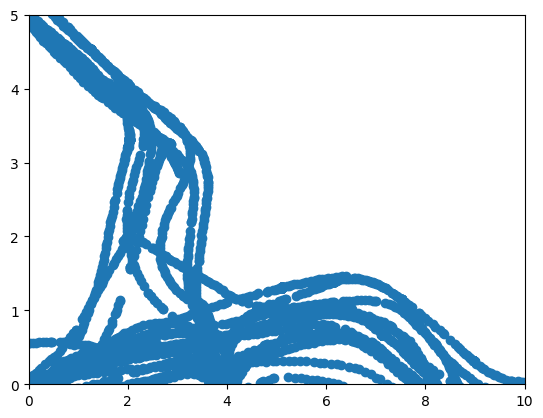

In [19]:
plot_data_coordinates(coordinates_fpmap)

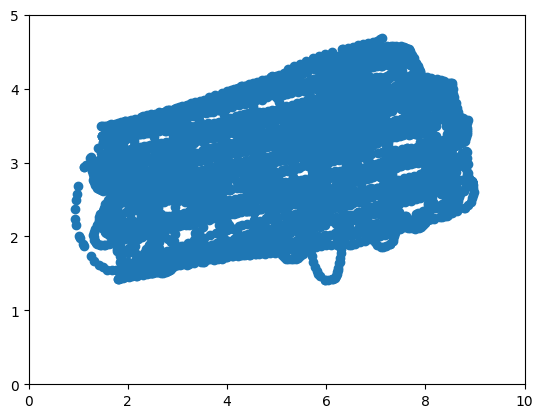

In [20]:
plot_data_coordinates(test_data_coordinates)

Audio Data

In [21]:
def data_audio(data):
  audio_data = np.delete(data, [-2, -1], axis=1)
  return audio_data

In [22]:
#samplerate
fs = 44100

In [23]:
audio_fpmap = data_audio(data_fpmap)

In [24]:
test_audio_fpmap0 = data_audio(data_test_fpmap0)

In [25]:
def data_freq_spec(data):
  fig, axs = plt.subplots(nrows=3, ncols=3, constrained_layout=False, figsize = (18,12))
  for n, ax in enumerate(axs.flat):
    ax.specgram(data[n*100,:], NFFT=512, Fs=fs); ax.set_ylim([18000, 22000])
    ax.set_ylabel('frequency')

Audio Data in Frequnecy Domain

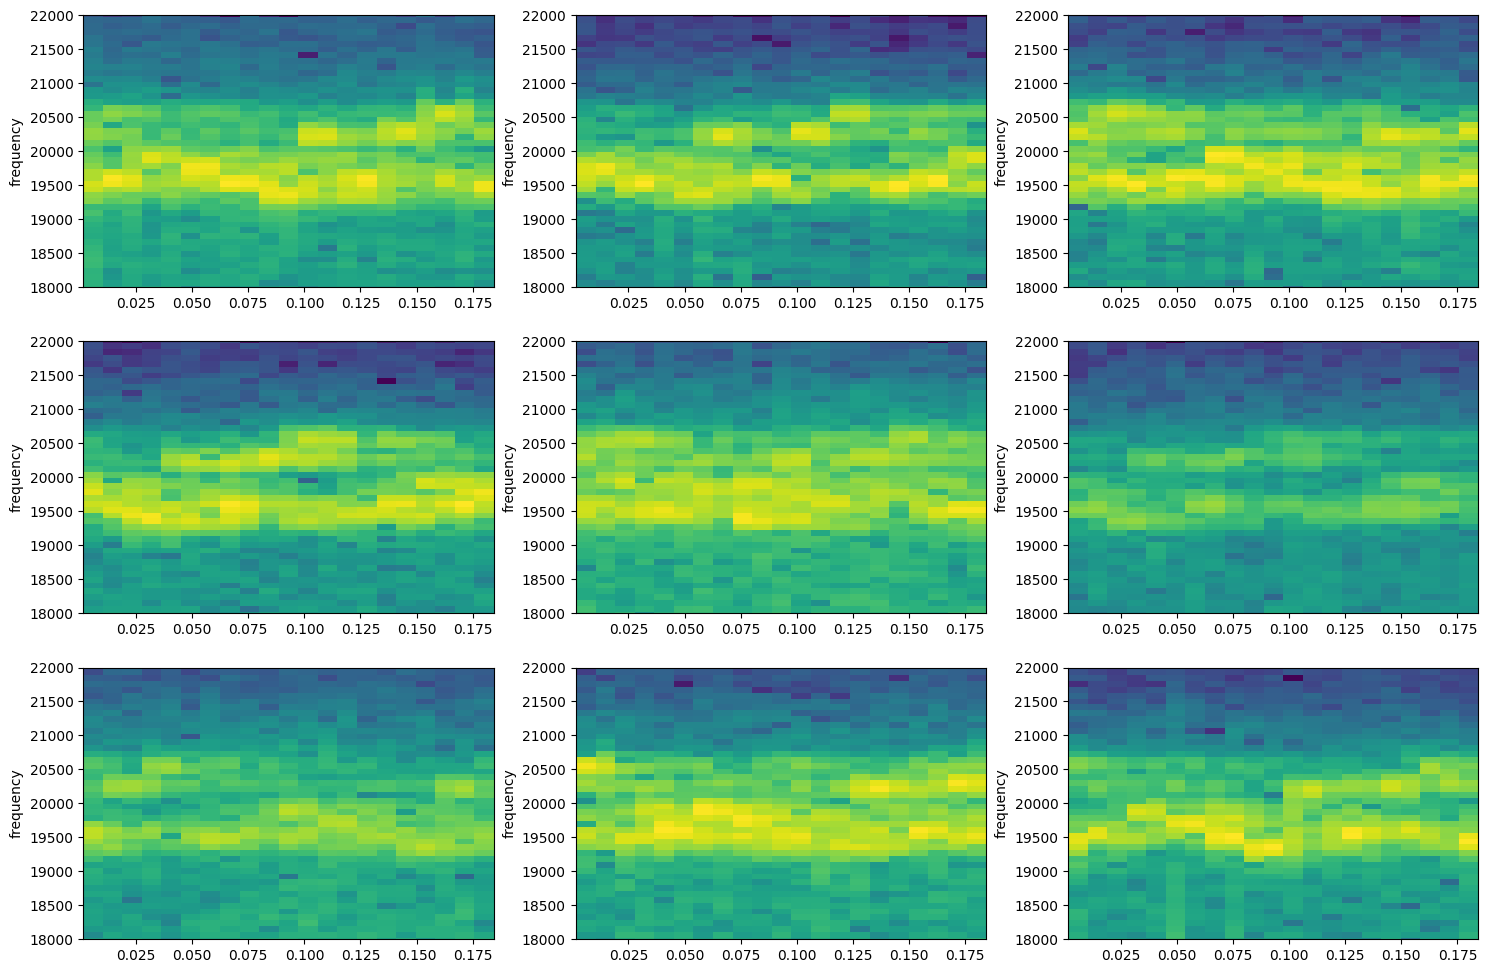

In [26]:
data_freq_spec(audio_fpmap)

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


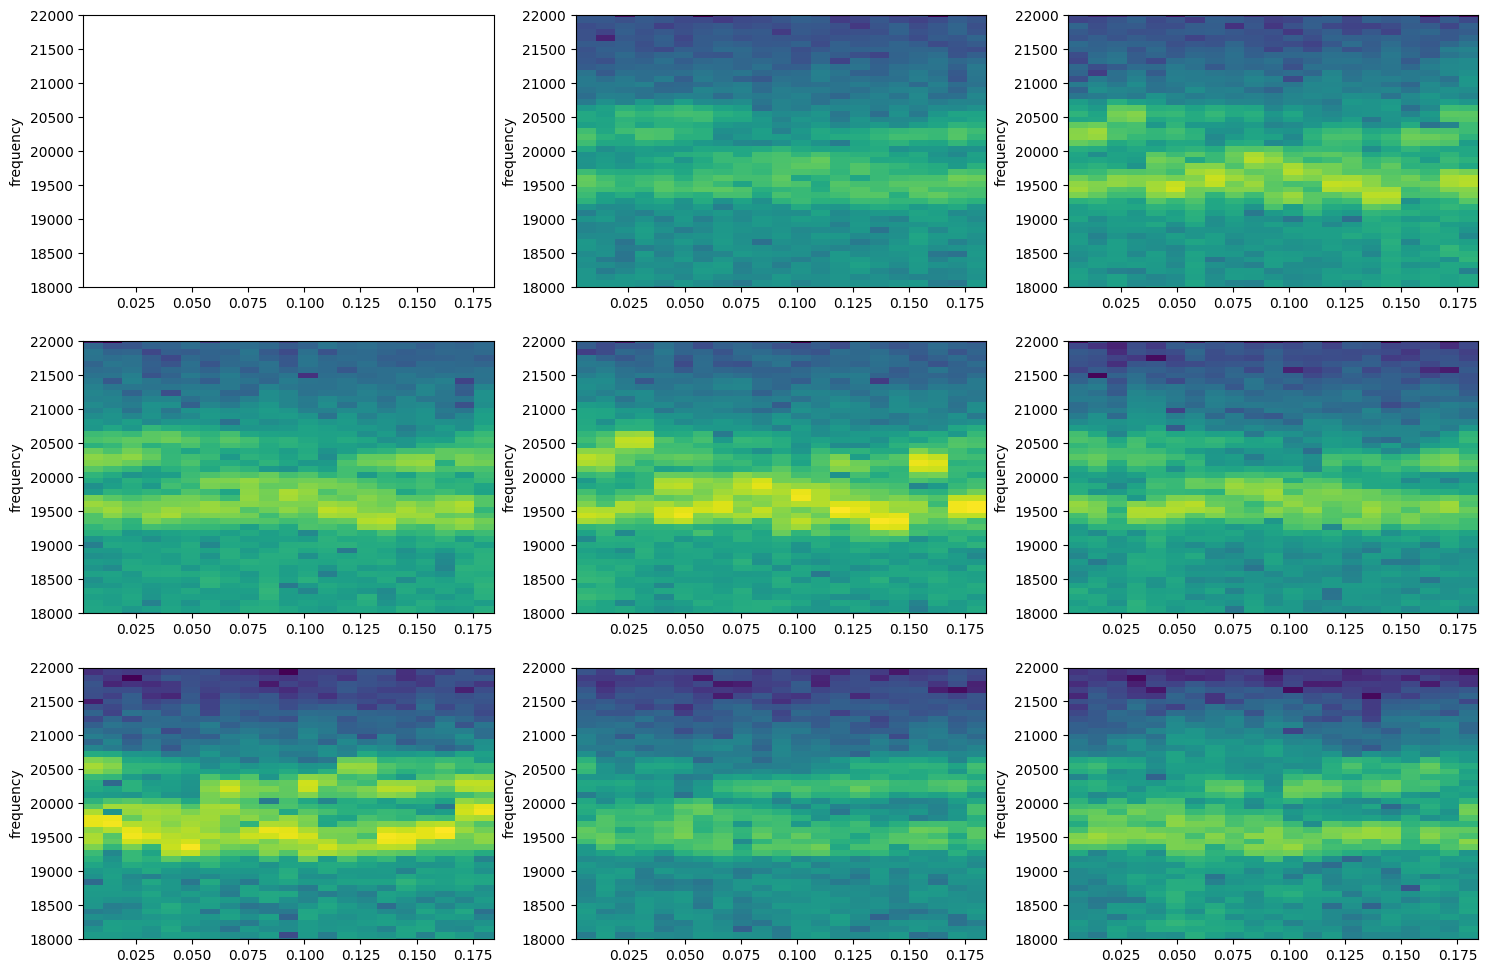

In [27]:
data_freq_spec(test_audio_fpmap0)

Short Time Fourier Transform

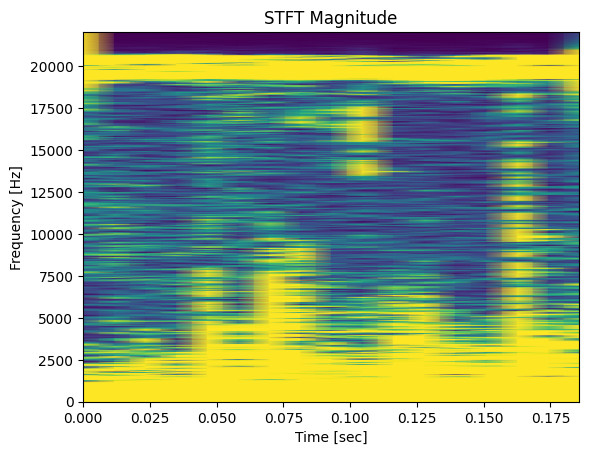

In [28]:
f, t, Zxx = signal.stft(audio_fpmap[150,:], fs, nperseg=1024)
amp = 2 * np.sqrt(2)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

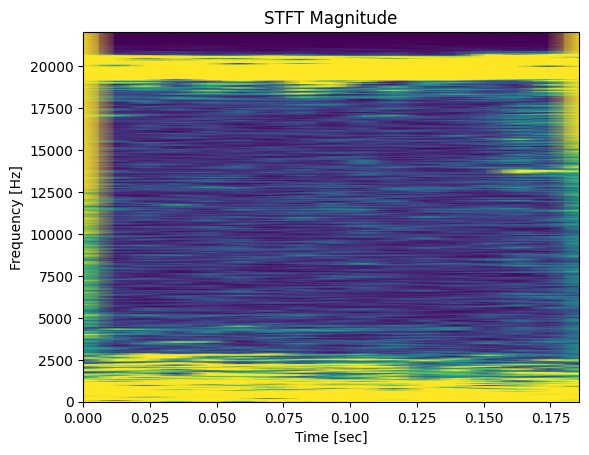

In [29]:
f, t, Zxx = signal.stft(audio_fpmap[2,:], fs, nperseg=1024)
amp = 2 * np.sqrt(2)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

**Preprocess data**

**High** Pass filter

In [30]:
def highpass_filter(data):
  highpass_freq = 10000  # Cutoff frequency for high-pass filter
  nyquist_freq = fs/2  # Nyquist frequency for the data
  highpass = highpass_freq / nyquist_freq
  b, a = signal.butter(4, highpass, btype='high')

  # Apply the high-pass filter to the input data
  data_highpass = signal.filtfilt(b, a, data)
  return data_highpass

In [31]:
#Highpass filter on fpmap
spectrogram_highpass_fpmap = highpass_filter(audio_fpmap)
spectrogram_highpass_fpmap.shape

(10412, 8192)

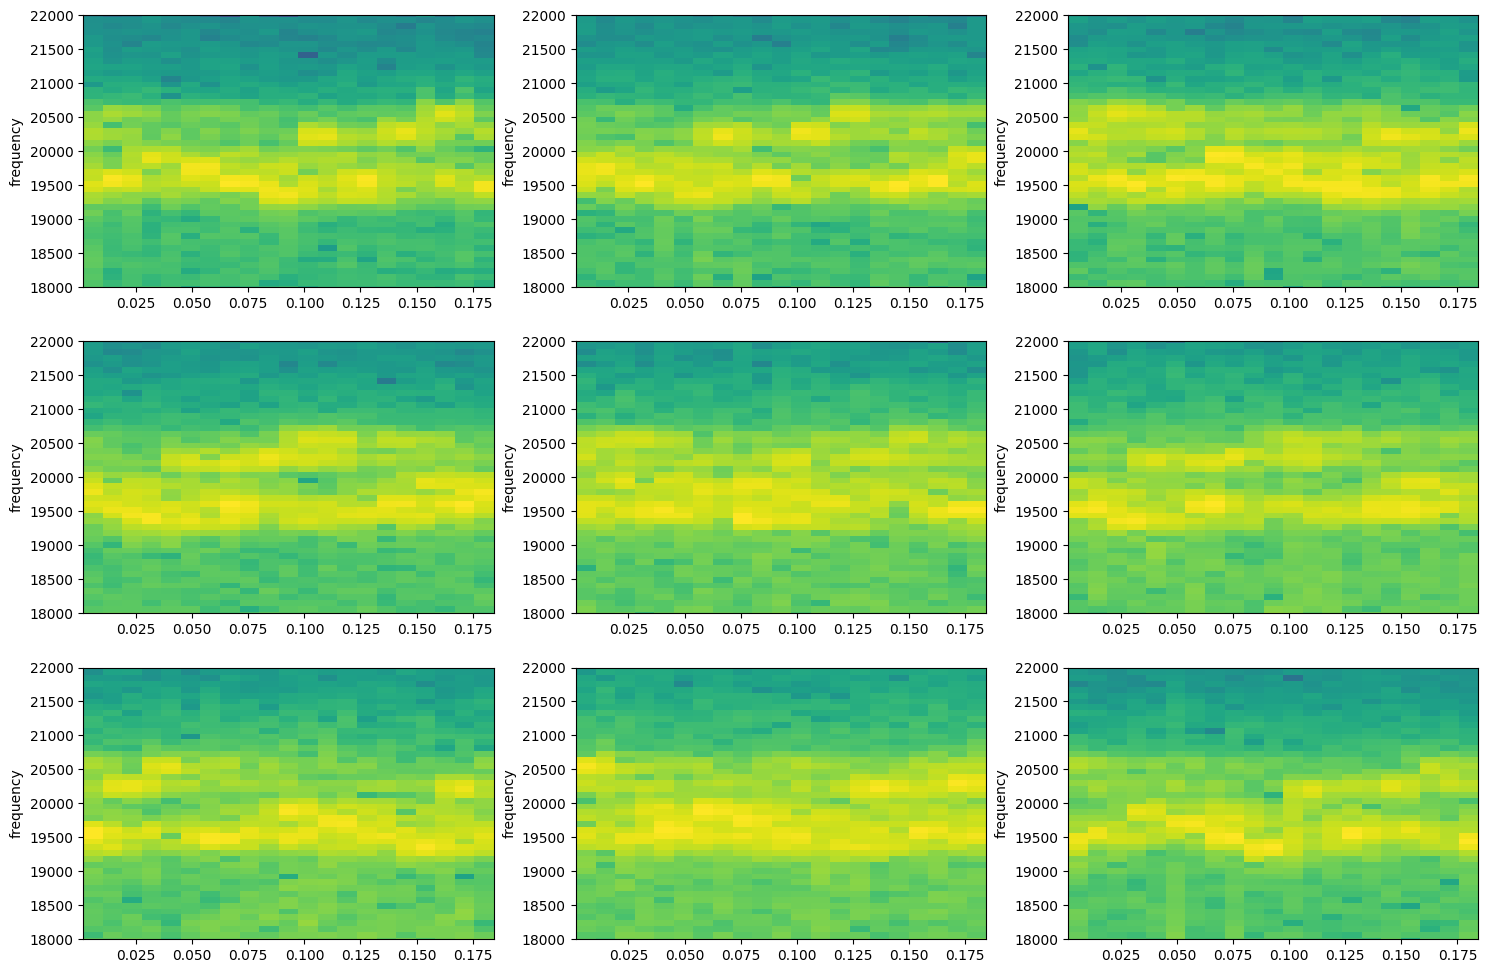

In [32]:
data_freq_spec(spectrogram_highpass_fpmap)

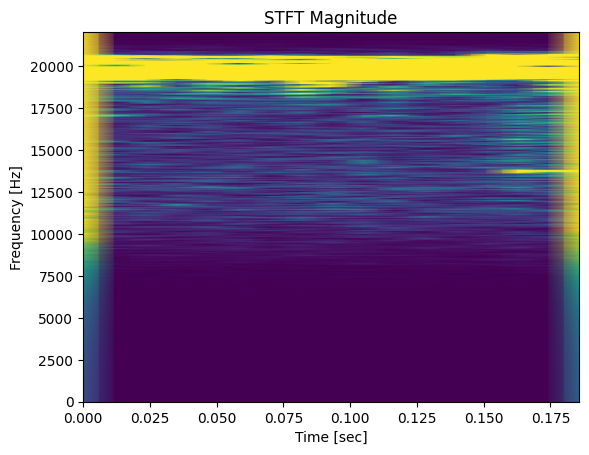

In [33]:
f, t, Zxx = signal.stft(spectrogram_highpass_fpmap[2,:], fs, nperseg=1024)
amp = 2 * np.sqrt(2)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

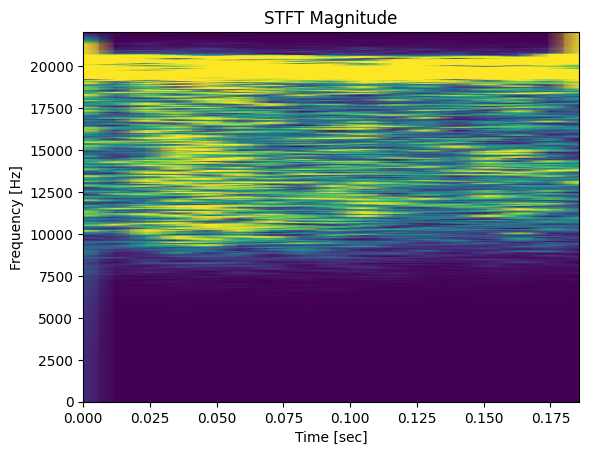

In [34]:
f, t, Zxx = signal.stft(spectrogram_highpass_fpmap[2000,:], fs, nperseg=1024)
amp = 2 * np.sqrt(2)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

Short Time Fourier Transform on audio data with highpass filter

In [35]:
def stft_Data(audiodata):
  audio_data = audiodata
  fs = 44100 # sampling rate
  nperseg = 1024 # number of samples per segment for STFT
  spectrograms = []
  #coordinates = coordinatesdata
  for audio in audio_data:
    f, t, Zxx = stft(audio, fs=fs, nperseg=nperseg)
    spectrograms.append(np.abs(Zxx)) #spectrogram for each audio sample
  spectrograms = np.array(spectrograms)
  spectrograms = np.expand_dims(spectrograms, -1)

  return spectrograms

In [36]:
stft_fpmap = stft_Data(audio_fpmap)

In [37]:
stft_fpmap.shape

(10412, 513, 17, 1)

In [38]:
test_stft_fpmap = stft_Data(test_audio_fpmap0)

# Normalize audio data

In [39]:
def normalize_Data(data):
  data = (data - np.min(data)) / (np.max(data) - np.min(data))
  return data

In [40]:
normalize_stft_fpmap0 = normalize_Data(stft_fpmap)


In [41]:
normalize_stft_fpmap0.shape


(10412, 513, 17, 1)

In [42]:
test_normalize_stft_fpmap0 = normalize_Data(test_stft_fpmap)
test_normalize_stft_fpmap0.shape


(6787, 513, 17, 1)

Split the data into training, testing and validation sets


In [43]:
X_train, X_test, y_train, y_test = train_test_split(normalize_stft_fpmap0, coordinates_fpmap, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [44]:
X_train.shape

(6663, 513, 17, 1)

In [45]:
y_train.shape

(6663, 2)

In [46]:
y_val.shape

(1666, 2)

In [47]:
X_val.shape

(1666, 513, 17, 1)

In [48]:
y_test.shape

(2083, 2)

In [49]:
X_test.shape

(2083, 513, 17, 1)

In [ ]:
Applyng Keras Tuner

In [ ]:
# Define the model creation function
def build_model(hp):
    # Define the model architecture
    model = tf.keras.Sequential()
    model.add(Input(shape=X_train.shape[1:]))
    model.add(Conv2D(hp.Int('conv1_units', min_value=50, max_value=52, step=2), kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int('conv2_units', min_value=110, max_value=112, step=2), kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int('conv3_units', min_value=46, max_value=48, step=2), kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int('conv4_units', min_value=30, max_value=32, step=2), kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense1_units', min_value=78, max_value=80, step=2), activation='relu', kernel_regularizer=regularizers.L1L2(hp.Float('l1_reg1', min_value=1e-6, max_value=1e-2, sampling='log'),hp.Float('l2_reg1', min_value=1e-6, max_value=1e-2, sampling='log'))))
    model.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('dense2_units', min_value=30, max_value=32, step=2), activation='relu', kernel_regularizer=regularizers.L1L2(hp.Float('l1_reg2', min_value=1e-6, max_value=1e-2, sampling='log'),hp.Float('l2_reg2', min_value=1e-6, max_value=1e-2, sampling='log'))))
    model.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(2, activation='linear'))

    # Compile the model with the specified learning rate and optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='mean_squared_error',
        metrics=['mse']
    )

    return model


In [ ]:
# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='koop_stft_model'
)

In [ ]:
# Perform the search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

In [ ]:
# Get the best model and print the summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 513, 17, 52)       520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 8, 52)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 8, 112)       52528     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 4, 112)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 4, 44)        44396     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 2, 44)        0

In [ ]:
tuner.results_summary()

Results summary
Results in my_dir/koop_stft_model
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 06 summary
Hyperparameters:
conv1_units: 52
conv2_units: 112
conv3_units: 44
conv4_units: 32
dense1_units: 80
l1_reg1: 0.0018952631956467565
l2_reg1: 0.0003322626367543581
dropout1: 0.5
dense2_units: 32
l1_reg2: 5.108290252612654e-05
l2_reg2: 0.004686235901376381
dropout2: 0.30000000000000004
learning_rate: 0.0009745998635814003
Score: 3.2749850749969482

Trial 04 summary
Hyperparameters:
conv1_units: 52
conv2_units: 108
conv3_units: 44
conv4_units: 32
dense1_units: 80
l1_reg1: 7.060097173258407e-06
l2_reg1: 0.0010345377228806847
dropout1: 0.1
dense2_units: 32
l1_reg2: 4.917035755105909e-06
l2_reg2: 0.0004563120987408676
dropout2: 0.4
learning_rate: 0.00024425847870161076
Score: 3.373753547668457

Trial 02 summary
Hyperparameters:
conv1_units: 56
conv2_units: 112
conv3_units: 48
conv4_units: 28
dense1_units: 84
l1_reg1: 0.00018212869818075257
l2_reg1: 0.0098313022

Model

In [ ]:
class KoopSTFTModel(tf.keras.Model):
    def __init__(self):
        super(KoopSTFTModel, self).__init__()
        self.input_layer = Input(shape=X_train.shape[1:])
        self.conv = Conv2D(52, kernel_size=(3,3),  padding='same', activation='relu')
        self.max_pool = MaxPooling2D(pool_size=(2, 2))
        self.conv2 = Conv2D(112, kernel_size=(3,3),  padding='same', activation='relu')
        self.max_pool2 = MaxPooling2D(pool_size=(2, 2))
        self.conv3 = Conv2D(32, kernel_size=(3,3),  padding='same', activation='relu')
        self.max_pool3 = MaxPooling2D(pool_size=(2, 2))
        self.conv4 = Conv2D(20, kernel_size=(3,3),  padding='same', activation='relu')
        self.max_pool4 = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.ds = Dense(72, activation='relu', kernel_regularizer=regularizers.L1L2(0.000013, 0.0003))
        self.dp = Dropout(0.15)
        self.ds2 = Dense(20, activation='relu', kernel_regularizer=regularizers.L1L2(0.000018, 0.0000035))
        self.dp2 = Dropout(0.1)
        self.finalOutput = Dense(2, activation='linear')


    def call(self, inputs):
        x = self.conv(inputs)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.conv3(x)
        x = self.max_pool3(x)
        x = self.conv4(x)
        x = self.max_pool4(x)
        x = self.flatten(x)
        x = self.ds(x)
        x = self.dp(x)
        x = self.ds2(x)
        x = self.dp2(x)
        x = self.finalOutput(x)
        return x



    # Calculate mean squared error
    def calMSE(self, y_test,y_pred):
      mse = mean_squared_error(y_test, y_pred)
      print("Mean Squared Error:", mse)
      return mse

    def export_model(self, file_path):
        self.model.save(file_path)



In [ ]:
#Instantiating Model using FpMap Single data
model_fpmapSingle = KoopSTFTModel()

In [ ]:
#compile
model_fpmapSingle.compile(optimizer= Adam(learning_rate=0.001), metrics=['mae'], loss='mean_squared_error')
# Train model
history = model_fpmapSingle.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
209/209 [==============================] - 4s 7ms/step - loss: 11.6609 - mae: 2.5476 - val_loss: 10.0087 - val_mae: 2.3865
Epoch 2/50
209/209 [==============================] - 1s 6ms/step - loss: 10.4850 - mae: 2.4412 - val_loss: 10.2704 - val_mae: 2.3239
Epoch 3/50
209/209 [==============================] - 1s 6ms/step - loss: 10.2731 - mae: 2.4222 - val_loss: 9.8694 - val_mae: 2.3963
Epoch 4/50
209/209 [==============================] - 1s 6ms/step - loss: 9.5131 - mae: 2.3012 - val_loss: 8.5478 - val_mae: 2.0754
Epoch 5/50
209/209 [==============================] - 1s 6ms/step - loss: 7.8297 - mae: 2.0652 - val_loss: 6.7036 - val_mae: 1.9174
Epoch 6/50
209/209 [==============================] - 1s 6ms/step - loss: 7.0183 - mae: 1.9548 - val_loss: 6.1302 - val_mae: 1.8331
Epoch 7/50
209/209 [==============================] - 1s 6ms/step - loss: 6.4984 - mae: 1.8817 - val_loss: 6.2969 - val_mae: 1.8086
Epoch 8/50
209/209 [==============================] - 1s 6ms/step - los

Predicting Coordinates

In [ ]:
y_pred = model_fpmapSingle.predict(X_test)

66/66 [==============================] - 0s 2ms/step


MSE as evaluaton Metrics

In [ ]:
model_fpmapSingle.calMSE(y_test,y_pred)

Mean Squared Error: 2.633684599212449


2.633684599212449

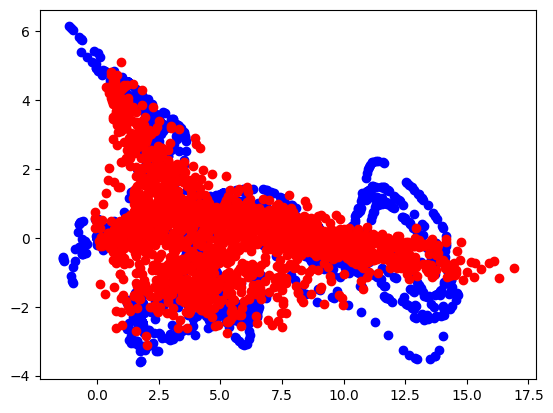

In [ ]:
# Plot the actual vs predicted coordinates
plt.scatter(y_test[:,0], y_test[:,1], color='blue')
plt.scatter(y_pred[:,0], y_pred[:,1], color='red')
plt.show()

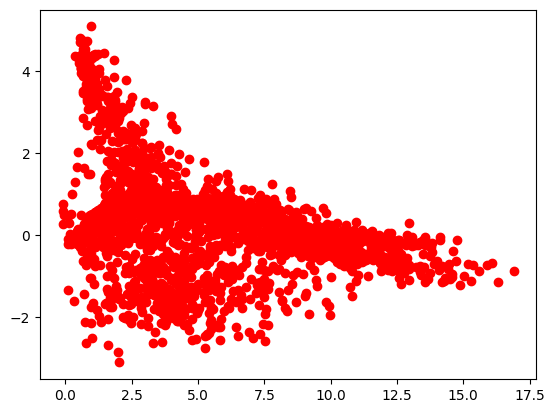

In [ ]:
plt.scatter(y_pred[:,0], y_pred[:,1], color='red')
plt.show()

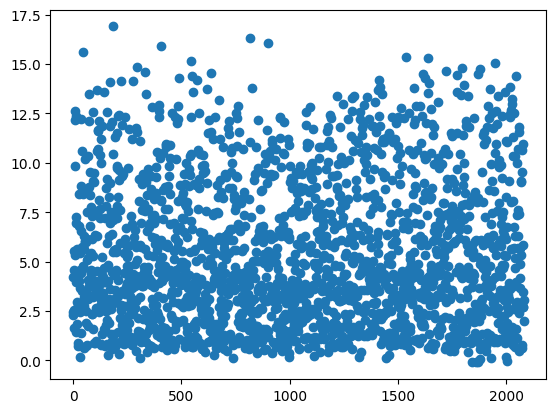

In [ ]:
plt.scatter(np.arange(y_pred[:,0].size), y_pred[:,0])

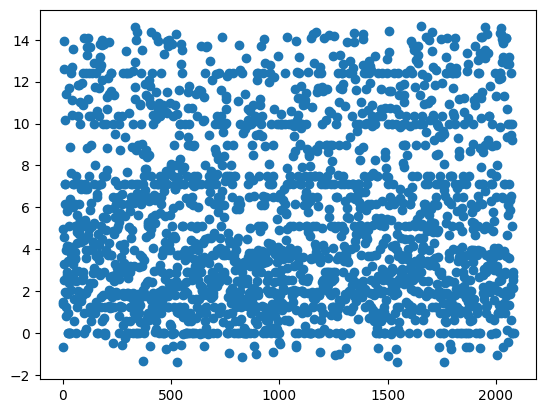

In [ ]:
plt.scatter(np.arange(y_test[:,0].size), y_test[:,0])

In [ ]:
y_pred

array([[ 2.470649  ,  2.682432  ],
       [ 2.2871847 ,  2.503815  ],
       [ 4.2060294 ,  0.9816542 ],
       ...,
       [ 2.681755  , -1.5977697 ],
       [ 3.0794523 ,  1.8944333 ],
       [ 2.0146134 ,  0.18206637]], dtype=float32)

In [ ]:
y_test

array([[ 1.39,  1.34],
       [-0.65, -0.25],
       [ 1.48,  4.08],
       ...,
       [ 2.15, -2.04],
       [ 2.73,  2.17],
       [ 0.  ,  0.  ]])

In [ ]:
r2_score(y_test, y_pred)

0.7090422856829426

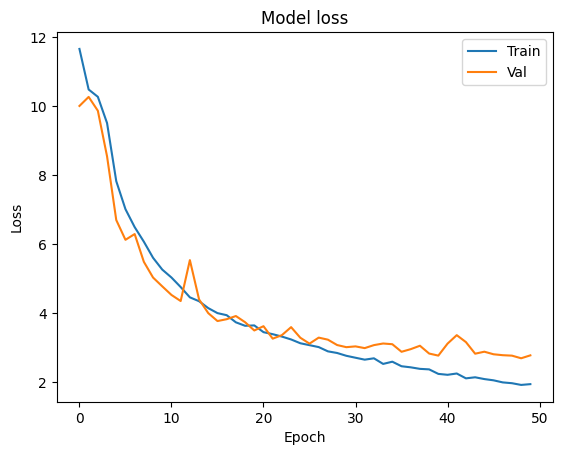

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

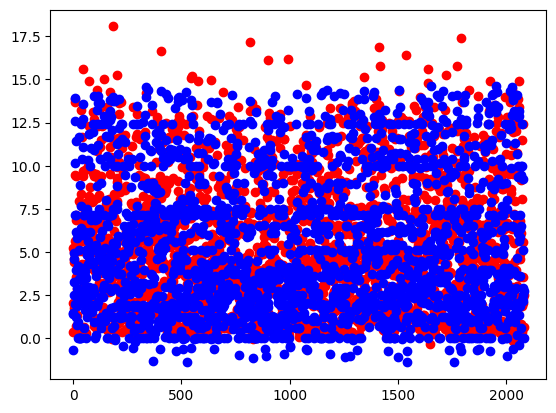

In [ ]:
plt.scatter(np.arange(y_pred[:,0].size), y_pred[:,0], color='red')
plt.scatter(np.arange(y_test[:,0].size), y_test[:,0], color='blue')
plt.show

In [ ]:
model_fpmapSingle.summary()

Model: "koop_stft_model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_184 (Conv2D)         multiple                  520       
                                                                 
 max_pooling2d_184 (MaxPooli  multiple                 0         
 ng2D)                                                           
                                                                 
 conv2d_185 (Conv2D)         multiple                  52528     
                                                                 
 max_pooling2d_185 (MaxPooli  multiple                 0         
 ng2D)                                                           
                                                                 
 conv2d_186 (Conv2D)         multiple                  32288     
                                                                 
 max_pooling2d_186 (MaxPooli  multiple          

Generalization

In [ ]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(test_normalize_stft_fpmap0, test_data_coordinates, test_size=0.2)
X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(X_train_t, y_train_t, test_size=0.2)


In [ ]:
X_train_t.shape

(4343, 513, 17, 1)

In [ ]:
X_test_t.shape

(1358, 513, 17, 1)

In [ ]:
X_val_t.shape

(1086, 513, 17, 1)

In [ ]:
model_fpmapTest = KoopSTFTModel()

In [ ]:
#compile
model_fpmapTest.compile(optimizer= Adam(learning_rate=0.001), metrics=['mae'], loss='mean_squared_error')
# Train model
history = model_fpmapTest.fit(X_train_t, y_train_t, epochs=50, validation_data=(X_val_t, y_val_t))

Epoch 1/50
136/136 [==============================] - 4s 8ms/step - loss: 4.4434 - mae: 1.6070 - val_loss: 3.1693 - val_mae: 1.2953
Epoch 2/50
136/136 [==============================] - 1s 6ms/step - loss: 2.6941 - mae: 1.2309 - val_loss: 2.1457 - val_mae: 1.1317
Epoch 3/50
136/136 [==============================] - 1s 6ms/step - loss: 2.2101 - mae: 1.0904 - val_loss: 1.7957 - val_mae: 0.9584
Epoch 4/50
136/136 [==============================] - 1s 6ms/step - loss: 1.9382 - mae: 1.0096 - val_loss: 1.6678 - val_mae: 0.8952
Epoch 5/50
136/136 [==============================] - 1s 6ms/step - loss: 1.7860 - mae: 0.9620 - val_loss: 1.4704 - val_mae: 0.8958
Epoch 6/50
136/136 [==============================] - 1s 6ms/step - loss: 1.7565 - mae: 0.9488 - val_loss: 1.4580 - val_mae: 0.8417
Epoch 7/50
136/136 [==============================] - 1s 6ms/step - loss: 1.6738 - mae: 0.9240 - val_loss: 1.3584 - val_mae: 0.8131
Epoch 8/50
136/136 [==============================] - 1s 6ms/step - loss: 1.

In [ ]:
y_pred_t = model_fpmapTest.predict(X_test_t)

43/43 [==============================] - 0s 2ms/step


In [ ]:
model_fpmapTest.calMSE(y_test_t,y_pred_t)

Mean Squared Error: 0.5726709669056401


0.5726709669056401

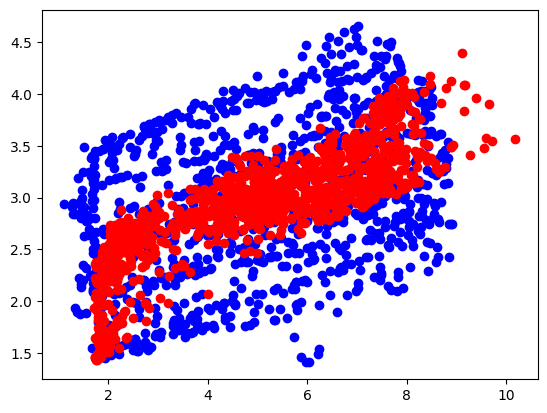

In [ ]:
# Plot the actual vs predicted coordinates
plt.scatter(y_test_t[:,0], y_test_t[:,1], color='blue')
plt.scatter(y_pred_t[:,0], y_pred_t[:,1], color='red')
plt.show()

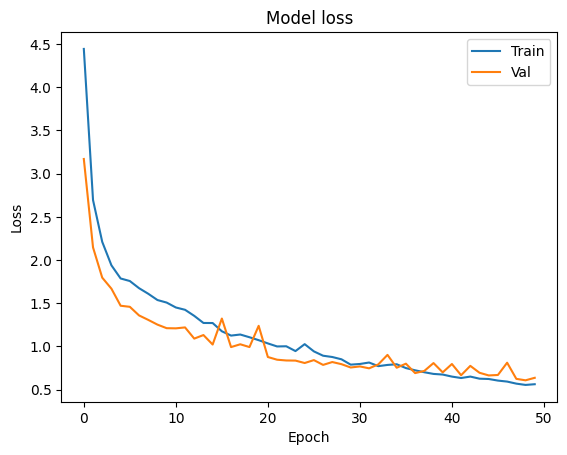

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

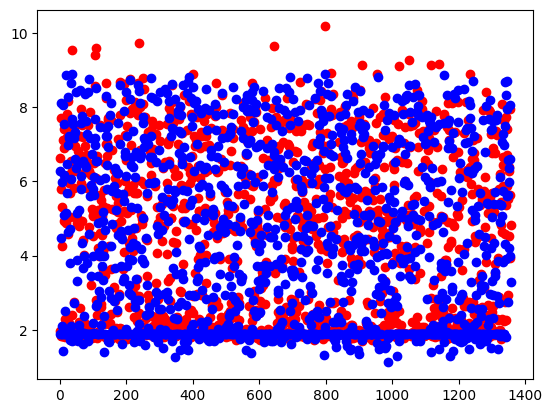

In [ ]:
plt.scatter(np.arange(y_pred_t[:,0].size), y_pred_t[:,0], color='red')
plt.scatter(np.arange(y_test_t[:,0].size), y_test_t[:,0], color='blue')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

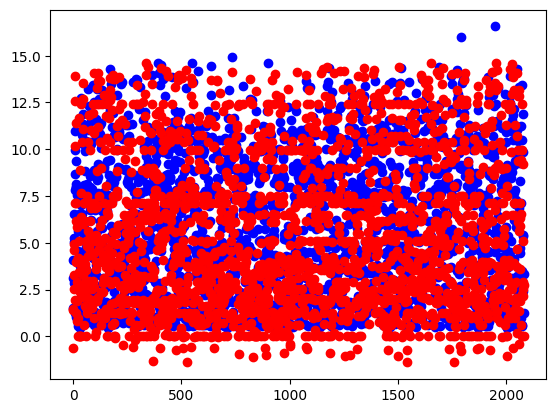

In [ ]:
plt.scatter(np.arange(y_pred_hp[:,0].size), y_pred_hp[:,0], color='blue')
plt.scatter(np.arange(y_test_hp[:,0].size), y_test_hp[:,0], color='red')
plt.show

Highpass Filter

In [ ]:
highpass_stft_fpmap = stft_Data(spectrogram_highpass_fpmap)

In [ ]:
highpass_stft_fpmap.shape

(10412, 513, 17, 1)

In [ ]:
normalize_stft_highpass_fpmap = normalize_Data(highpass_stft_fpmap)

In [ ]:
X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(normalize_stft_highpass_fpmap, coordinates_fpmap, test_size=0.2, random_state=42)
X_train_hp, X_val_hp, y_train_hp, y_val_hp = train_test_split(X_train_hp, y_train_hp, test_size=0.2, random_state=42)

In [ ]:
model_fpmapHighPass = KoopSTFTModel()


In [ ]:

model_fpmapHighPass.compile(optimizer= Adam(learning_rate=0.001), metrics=['mae'], loss='mean_squared_error')
# Train model with 50 epochs

history = model_fpmapHighPass.fit(X_train_hp, y_train_hp, epochs=50, validation_data=(X_val_hp, y_val_hp))

Epoch 1/50
209/209 [==============================] - 4s 7ms/step - loss: 11.1201 - mae: 2.4956 - val_loss: 9.9886 - val_mae: 2.3835
Epoch 2/50
209/209 [==============================] - 1s 6ms/step - loss: 10.1813 - mae: 2.3975 - val_loss: 9.6800 - val_mae: 2.3683
Epoch 3/50
209/209 [==============================] - 1s 6ms/step - loss: 9.6047 - mae: 2.2986 - val_loss: 9.0366 - val_mae: 2.2197
Epoch 4/50
209/209 [==============================] - 1s 6ms/step - loss: 8.6610 - mae: 2.1360 - val_loss: 8.0160 - val_mae: 2.0136
Epoch 5/50
209/209 [==============================] - 1s 6ms/step - loss: 8.0787 - mae: 2.0485 - val_loss: 7.7872 - val_mae: 1.9163
Epoch 6/50
209/209 [==============================] - 1s 6ms/step - loss: 7.2986 - mae: 1.9363 - val_loss: 7.7577 - val_mae: 1.9038
Epoch 7/50
209/209 [==============================] - 1s 6ms/step - loss: 6.6384 - mae: 1.8504 - val_loss: 6.2112 - val_mae: 1.7496
Epoch 8/50
209/209 [==============================] - 1s 6ms/step - loss: 

In [ ]:
model_fpmapHighPass.summary()

Model: "koop_stft_model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_188 (Conv2D)         multiple                  520       
                                                                 
 max_pooling2d_188 (MaxPooli  multiple                 0         
 ng2D)                                                           
                                                                 
 conv2d_189 (Conv2D)         multiple                  52528     
                                                                 
 max_pooling2d_189 (MaxPooli  multiple                 0         
 ng2D)                                                           
                                                                 
 conv2d_190 (Conv2D)         multiple                  32288     
                                                                 
 max_pooling2d_190 (MaxPooli  multiple          

In [ ]:
y_pred_hp = model_fpmapHighPass.predict(X_test_hp)
# Calculate mean squared error
model_fpmapHighPass.calMSE(y_test_hp,y_pred_hp)

66/66 [==============================] - 0s 2ms/step
Mean Squared Error: 4.500333097925532


4.500333097925532

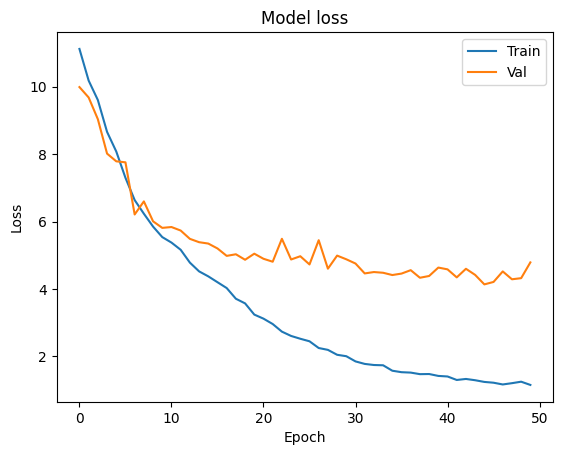

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
y_pred_hp

array([[ 7.4676285 ,  0.7865182 ],
       [ 5.3629026 , -0.34305423],
       [ 2.686132  ,  2.244609  ],
       ...,
       [ 3.1343932 , -1.9379938 ],
       [ 5.0858474 ,  0.63122916],
       [ 1.7567443 ,  0.44248664]], dtype=float32)

In [ ]:
y_test_hp

array([[ 1.39,  1.34],
       [-0.65, -0.25],
       [ 1.48,  4.08],
       ...,
       [ 2.15, -2.04],
       [ 2.73,  2.17],
       [ 0.  ,  0.  ]])

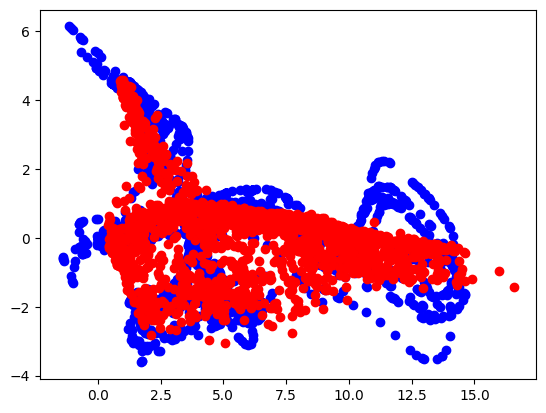

In [ ]:
# Plot the actual vs predicted coordinates
plt.scatter(y_test_hp[:,0], y_test_hp[:,1], color='blue')
plt.scatter(y_pred_hp[:,0], y_pred_hp[:,1], color='red')
plt.show()

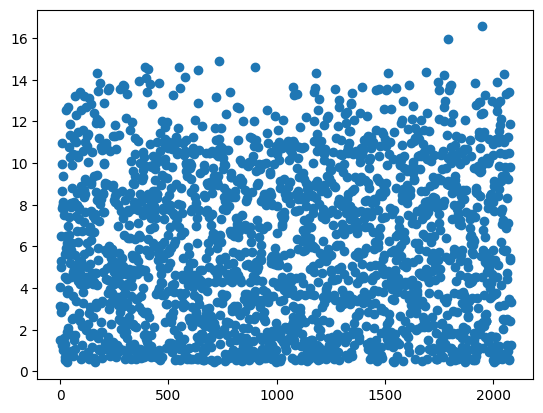

In [ ]:
plt.scatter(np.arange(y_pred_hp[:,0].size), y_pred_hp[:,0])

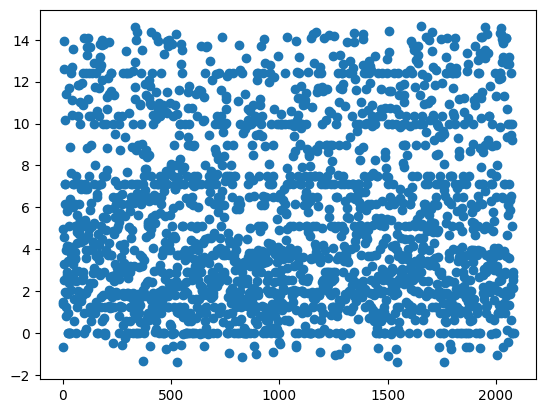

In [ ]:
plt.scatter(np.arange(y_test_hp[:,0].size), y_test_hp[:,0])

In [ ]:
r2_score(y_test_hp, y_pred_hp)

0.5402439483773234